In [1]:
import sys, json, io
with open('../data/Феодосийское.geojson') as f:
    input_json = json.load(f)

In [2]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType

# We'll use Sentinel-2 imagery (Level-1C) provided through Sentinel Hub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.

from eolearn.io import SentinelHubInputTask
from eolearn.core import LoadFromDisk, SaveToDisk

from eolearn.mask import AddValidDataMaskTask

# filtering of scenes
from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRaster

In [3]:
# The golden standard: numpy and matplotlib
import numpy as np

# import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# Image manipulations
# Our water detector is going to be based on a simple threshold 
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# Loading polygon of nominal water extent
import shapely.wkt
from shapely.geometry import Polygon

# sentinelhub-py package
from sentinelhub import BBox, CRS, DataCollection, SHConfig

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/vlas/.local/lib/python3.8/site-packages/ipykernel/pylab/config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [5]:
CLIENT_ID = '705de065-d047-4187-b8d2-01386b232165'
CLIENT_SECRET = 'U3n%1|B*pa@GvjA}UvxgyO@!RT-o}C}r1T?#7SwN'
    
config = SHConfig()
config.instance_id = '274430c0-0c82-493a-95c6-694e4640cf14'
    
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
if config.sh_client_id == '' or config.sh_client_secret == '' or config.instance_id == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
# config.save()

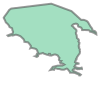

In [7]:
from shapely.geometry import shape

dam_nominal = shape(input_json["features"][0]["geometry"])
# print(dam_nominal)
# inflate the BBOX 
inflate_bbox = 0 #0.1
minx, miny, maxx, maxy = dam_nominal.bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox
    
dam_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)
dam_nominal

# for geom in dam_nominal.geoms:
#     plt.plot(*geom.exterior.xy)


In [8]:
download_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=20, 
                                     maxcc=0.5, 
                                     bands=['B02', 'B03', 'B04', 'B08'], 
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'), (FeatureType.MASK, 'CLM')],
                                     config=config
                                    )

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

In [9]:
dam_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[dam_nominal])


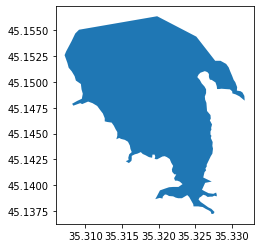

In [10]:
dam_gdf.plot();

In [11]:
add_nominal_water = VectorToRaster(dam_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

In [12]:


def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):
    
    def execute(self, eopatch):
        
        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape
        
        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch
    
add_coverage = AddValidDataCoverage()

In [14]:
cloud_coverage_threshold = 0.05 

class ValidDataCoveragePredicate:
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        return calculate_coverage(array) < self.threshold
    
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

In [15]:
class WaterDetector(EOTask):
    
    @staticmethod
    def detect_water(ndwi):
        """
        Very simple water detector based on Otsu thresholding method of NDWI.
        """
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) 
                                   for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch
    
water_detection = WaterDetector()

In [16]:
workflow = LinearWorkflow(download_task, calculate_ndwi, add_nominal_water, add_valid_mask,
                          add_coverage, remove_cloudy_scenes, water_detection)

In [17]:
time_interval = ['2021-01-06','2021-05-06']

In [18]:
result = workflow.execute({
    download_task: {
        'bbox': dam_bbox,
        'time_interval': time_interval
    },
})

<ipython-input-12-1d363147cad0>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
<ipython-input-12-1d363147cad0>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)


In [19]:
eopatch = list(result.values())[-1]

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [21]:
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon

def mask_to_polygons_layer(mask, eopatch, tolerance):
    
    all_polygons = []
    bbox = eopatch.bbox
    size_x = eopatch.meta_info['size_x']
    size_y = eopatch.meta_info['size_y']
    
    vx = bbox.min_x
    vy = bbox.max_y
    cx = (bbox.max_x-bbox.min_x)/size_x
    cy = (bbox.max_y-bbox.min_y)/size_y
    
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask == 1), transform=rasterio.Affine(cx, 0.0, vx,
       0.0, -cy, vy)): 
        return shapely.geometry.shape(shape).simplify(tolerance, False)
        all_polygons.append(shapely.geometry.shape(shape))
    
    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    return all_polygons


def toGeoJson (shape):
    return json.dumps(shapely.geometry.mapping(shape))


In [22]:

def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    
    tolerance = 0.00025
    
    observed = eopatch.mask['WATER_MASK'][idx,...,0]
    observed = dilation(observed)
    observed = np.ma.masked_where(observed == False, observed)
    observedShape = mask_to_polygons_layer(observed, eopatch, tolerance)# вернуть
    return toGeoJson(observedShape)

In [23]:
# geometry
fetch_data = plot_rgb_w_water(eopatch, 0)

In [24]:
plot_rgb_w_water(eopatch, 0)

'{"type": "Polygon", "coordinates": [[[35.318670881555434, 45.15579441209855], [35.323387917051924, 45.15474475503337], [35.324960262217424, 45.15352015512399], [35.325746434800166, 45.15229555521462], [35.326532607382916, 45.15247049805882], [35.32705672243808, 45.15194566952623], [35.326532607382916, 45.15142084099364], [35.324960262217424, 45.15142084099364], [35.324960262217424, 45.151070955305244], [35.32391203210709, 45.15054612677265], [35.324174089634674, 45.14949646970747], [35.32548437727259, 45.14949646970747], [35.32548437727259, 45.148271869798094], [35.324960262217424, 45.1479219841097], [35.325222319745, 45.145822669979346], [35.324960262217424, 45.145822669979346], [35.324960262217424, 45.14494795575836], [35.32391203210709, 45.14407324153738], [35.322601744469175, 45.14407324153738], [35.32155351435885, 45.14494795575836], [35.31971911166577, 45.144773012914165], [35.319457054138184, 45.14547278429095], [35.31971911166577, 45.145822669979346], [35.318670881555434, 45.1

In [25]:
plot_rgb_w_water(eopatch, -5)

'{"type": "Polygon", "coordinates": [[[35.316836478862356, 45.15579441209855], [35.32050528424851, 45.15579441209855], [35.323387917051924, 45.15491969787757], [35.32469820468984, 45.15404498365658], [35.32548437727259, 45.15282038374721], [35.32627054985533, 45.15282038374721], [35.327580837493244, 45.15194566952623], [35.32705672243808, 45.15124589814944], [35.325222319745, 45.15142084099364], [35.324174089634674, 45.15054612677265], [35.32443614716225, 45.14967141255167], [35.325222319745, 45.149846355395866], [35.325746434800166, 45.14949646970747], [35.325746434800166, 45.148271869798094], [35.325222319745, 45.1480969269539], [35.325746434800166, 45.147047269888716], [35.32548437727259, 45.147047269888716], [35.325222319745, 45.14494795575836], [35.325746434800166, 45.14389829869318], [35.32548437727259, 45.14389829869318], [35.325222319745, 45.14179898456282], [35.32469820468984, 45.141449098874425], [35.324960262217424, 45.140224498965054], [35.32312585952434, 45.13882495621148]

In [26]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20,7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            'bo-',alpha=0.7, label='Water Level')
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            '--',color='gray',alpha=0.7, label='Cloud Coverage')
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water Level')
    ax.set_title('Detected Water Level')
    ax.grid(axis='y')
    ax.legend(loc='best')
    return ax

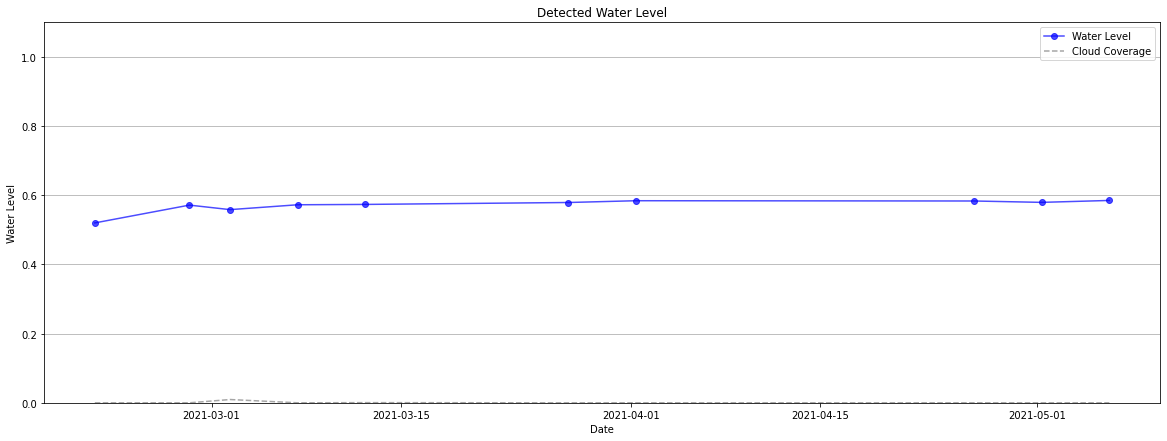

In [27]:
ax = plot_water_levels(eopatch, 1.0);

In [28]:
eopatch #COVERAGE  WATER_LEVEL  bbox+CRS  timestamp

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 109, 94, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 109, 94, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 109, 94, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(10, 109, 94, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(10, 109, 94, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(10, 109, 94, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(10, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(10, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(109, 94, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 94
    size_y: 109
    time_difference: datetime.timedelta(seconds=1)
    time_interval: (datetime.datetime(2021, 1, 6, 0, 0), datetime.datetime(2021, 5, 6, 23, 59, 59))
  }
  bbox: BBox(((35.307140350341

In [29]:
def get_observed_shape(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    
    tolerance = 0.00025
    
    observed = eopatch.mask['WATER_MASK'][idx,...,0]
    observed = dilation(observed)
    observed = np.ma.masked_where(observed == False, observed)
    observedShape = mask_to_polygons_layer(observed, eopatch, tolerance)
    return toGeoJson(observedShape)

In [30]:
output = []

for i in range(len(eopatch.scalar['WATER_LEVEL'])):
    numpyData = {"measurement_date": eopatch.timestamp[i].strftime('%d/%m/%Y'), "bbox": eopatch.bbox.geometry.bounds, "crs": eopatch.bbox.crs.epsg, "water_level": eopatch.scalar['WATER_LEVEL'][i,0], "cloud_coverage": eopatch.scalar['COVERAGE'][i,0], "measurement_type": "observed"}
    obJect = {"type": "Feature", "properties": numpyData, "geometry": get_observed_shape(eopatch, i)}
    output.append(obJect)
output
# output_json = json.dumps(output, ensure_ascii=False).encode('utf-8')
# json.dump(output, open("result.json","w"))


45.14512289860256], [35.319457054138184, 45.145297841446755], [35.319457054138184, 45.145822669979346], [35.318670881555434, 45.14617255566774], [35.318408824027856, 45.147047269888716], [35.31736059391752, 45.147047269888716], [35.31709853638994, 45.14652244135613], [35.31631236380719, 45.146347498511936], [35.31605030627961, 45.14669738420033], [35.31631236380719, 45.14739715557711], [35.31500207616928, 45.1480969269539], [35.31500207616928, 45.14844681264229], [35.31395384605894, 45.14844681264229], [35.313691788531365, 45.148796698330685], [35.312905615948615, 45.14844681264229], [35.31080915572795, 45.14862175548649], [35.310547098200374, 45.14914658401908], [35.31080915572795, 45.14949646970747], [35.309760925617624, 45.15002129824006], [35.30949886809004, 45.15194566952623], [35.30845063797971, 45.15299532659141], [35.308712695507296, 45.15421992650078], [35.31028504067279, 45.15491969787757], [35.316836478862356, 45.15579441209855]]]}'},
 {'type': 'Feature',
  'properties': {'m

In [45]:
output = []
list = range(len(eopatch.scalar['WATER_LEVEL']))

for i,element in enumerate(list):

    numpyData = {"measurement_date": eopatch.timestamp[i-1].strftime('%d/%m/%Y'), "bbox": eopatch.bbox.geometry.bounds, "crs": eopatch.bbox.crs.epsg, "water_level": eopatch.scalar['WATER_LEVEL'][i-1,0], "cloud_coverage": eopatch.scalar['COVERAGE'][i-1,0], "measurement_type": "observed"}

    obJect = {"type": "FeatureCollection", "features":[{"type":"Feature", "properties": numpyData, "geometry": get_observed_shape(eopatch, i-1)}]}
    output.append(obJect)

    if (i==len(list)-1):

        numpyData_last = {"measurement_date": eopatch.timestamp[element].strftime('%d/%m/%Y'), "bbox": eopatch.bbox.geometry.bounds, "crs": eopatch.bbox.crs.epsg, "water_level": eopatch.scalar['WATER_LEVEL'][element,0], "cloud_coverage": eopatch.scalar['COVERAGE'][element,0], "measurement_type": "observed"}
        obJect_last = {"last_observation": {"type": "FeatureCollection", "features":[{"type":"Feature", "properties": numpyData_last, "geometry": get_observed_shape(eopatch, element)}]}}

        output.append(obJect_last)


output
    



45.14844681264229], [35.31080915572795, 45.14862175548649], [35.310547098200374, 45.14914658401908], [35.31080915572795, 45.14949646970747], [35.309760925617624, 45.15002129824006], [35.30949886809004, 45.15194566952623], [35.30845063797971, 45.15299532659141], [35.308712695507296, 45.15421992650078], [35.31028504067279, 45.15491969787757], [35.316836478862356, 45.15579441209855]]]}'}]},
 {'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'properties': {'measurement_date': '02/03/2021',
     'bbox': (35.3071403503418,
      45.13725047061371,
      35.33177375793457,
      45.15631924063114),
     'crs': 4326,
     'water_level': 0.5584158415841585,
     'cloud_coverage': 0.009467109115752437,
     'measurement_type': 'observed'},
    'geometry': '{"type": "Polygon", "coordinates": [[[35.316836478862356, 45.15579441209855], [35.31998116919335, 45.15579441209855], [35.32312585952434, 45.15491969787757], [35.324174089634674, 45.154394869344976], [35.325222319745, 45.152

In [40]:
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 109, 94, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 109, 94, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 109, 94, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(10, 109, 94, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(10, 109, 94, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(10, 109, 94, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(10, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(10, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(109, 94, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 94
    size_y: 109
    time_difference: datetime.timedelta(seconds=1)
    time_interval: (datetime.datetime(2021, 1, 6, 0, 0), datetime.datetime(2021, 5, 6, 23, 59, 59))
  }
  bbox: BBox(((35.307140350341